# 1. Context & Data Understanding

**Objective:** Analyze historical credit application data to identify risk patterns and default behavior.
<br><br>
**Context:** The ultimate goal is to analyze the correlation between the `TARGET` variable (0 = Payer, 1 = Defaulter) and auxiliary variables to identify patterns and pre-diagnose potential good or bad payers, aiming to minimize financial losses.
<br><br>
**Methodology:** We will apply the **Data Understanding** phase of the **CRISP-DM** methodology to collect, comprehend, and select the most relevant data for analysis. In this step, we will perform a technical diagnosis of data quality ("Sanity Check") to guide the subsequent Data Cleaning (ETL) stage.

## 1.1 Library Import and Configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuration to see all the columns with Pandas
pd.set_option('display.max_columns', None)

# Chart styles
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (7, 6)

## 1.2 Data Collection

All data used in this project is publicly available on Kaggle.
The data was obtained via the Kaggle API and stored locally in `data/`. In total, 10 `.csv` files were imported.

Link to Kaggle repository: https://www.kaggle.com/datasets/megancrenshaw/home-credit-default-risk 

We will start by utilizing the `HomeCredit_columns_description.csv` file to gain a deeper understanding of our features and identify the most relevant ones. By the end of this section, we will select the variables for analysis and formulate key hypotheses to be validated throughout the project.

## 1.3 Problem Domain Definition & Variable Selection

In this project phase, we will focus exclusively on the `application_train.csv` table, as it alone provides valuable insights and allows us to analyze key variables influencing client default risk.

The original `application_train` dataset contains **122 columns**. Conducting an Exploratory Data Analysis (EDA) on all variables simultaneously would generate excessive noise and obscure clear business patterns.

Therefore, we will adopt a **Business Domain-Driven** approach to initially filter the dataset. We will focus on variables representing the fundamental pillars of credit analysis (**The 5 Cs of Credit**), reducing dimensionality to a manageable and interpretable subset.

To assist in this process, we will utilize the data dictionary available in `data/HomeCredit_columns_description.csv` to select the most relevant features.

In [3]:
#Loading the description file
desc_df = pd.read_csv('../data/HomeCredit_columns_description.csv', sep=',')

# Creating a function to filter descriptions for specific tables
selected_table = 'application_{train|test}.csv'
description_list = desc_df[desc_df['Table'] == selected_table].drop(columns=['Table', 'Unnamed: 0']) # Removing unnecessary columns

description_list

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


Aiming to apply business domain knowledge, we selected the features based on the **5 Cs of Credit** framework (Character, Capacity, Capital, Collateral, Conditions):

1. **Core Variables**
    - `TARGET`: Target variable (0 = Payer, 1 = Payment Difficulties)
    - `SK_ID_CURR`: Unique loan identifier
    - `NAME_CONTRACT_TYPE`: Loan type (Cash or Revolving)

2. **Client Financial Health**
    - `AMT_INCOME_TOTAL`: Total income
    - `AMT_CREDIT`: Credit amount requested
    - `AMT_ANNUITY`: Loan annuity amount
    - `AMT_GOODS_PRICE`: Price of goods (for consumer loans)

3. **Client Profile (Demographics)**
    - `CODE_GENDER`: Gender
    - `DAYS_BIRTH`: Client's age in days
    - `NAME_EDUCATION_TYPE`: Level of highest education
    - `NAME_FAMILY_STATUS`: Family status
    - `CNT_CHILDREN`: Number of children
    - `REGION_RATING_CLIENT`: Rating of the region where client lives

4. **Stability & Employment**
    - `DAYS_EMPLOYED`: Days employed
    - `NAME_INCOME_TYPE`: Income type (Businessman, working, pensioner, etc.)
    - `OCCUPATION_TYPE`: Client's occupation

5. **Assets & External Score**
    - `FLAG_OWN_CAR` & `OWN_CAR_AGE`: Flag if client owns a car and its age
    - `FLAG_OWN_REALTY`: Flag if client owns a house or flat
    - `EXT_SOURCE_1`, `2`, & `3`: Normalized scores from external data sources (Critical for risk assessment)

In [4]:
#Separating only selected columns
selected_columns = [
    'TARGET', 'SK_ID_CURR',
    'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 
    'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'CODE_GENDER', 'CNT_CHILDREN', 'DAYS_BIRTH', 
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'DAYS_EMPLOYED', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'OWN_CAR_AGE',
    'REGION_RATING_CLIENT', 
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

df = pd.read_csv('../data/application_train.csv', usecols=selected_columns)

## 1.4 Data Description

Post-filtering, we will analyze the key characteristics of the selected dataset.

### 1.4.1 Overview & Data Types
We will analyze the basic structure, data types, and dataset dimensions.

In [5]:
# Initial view of the dataset
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,-9461,-637,NaN,Laborers,2,0.083037,0.262949,0.139376
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,-16765,-1188,NaN,Core staff,1,0.311267,0.622246,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,-19046,-225,26.0,Laborers,2,NaN,0.555912,0.729567
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,-19005,-3039,NaN,Laborers,2,NaN,0.650442,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,-19932,-3038,NaN,Core staff,2,NaN,0.322738,NaN


In [6]:
# Dataset size and infos
print(f"Lines: {df.shape[0]}")
print(f"Columns: {df.shape[1]}\n")
df.info()

Lines: 307511
Columns: 22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SK_ID_CURR            307511 non-null  int64  
 1   TARGET                307511 non-null  int64  
 2   NAME_CONTRACT_TYPE    307511 non-null  object 
 3   CODE_GENDER           307511 non-null  object 
 4   FLAG_OWN_CAR          307511 non-null  object 
 5   FLAG_OWN_REALTY       307511 non-null  object 
 6   CNT_CHILDREN          307511 non-null  int64  
 7   AMT_INCOME_TOTAL      307511 non-null  float64
 8   AMT_CREDIT            307511 non-null  float64
 9   AMT_ANNUITY           307499 non-null  float64
 10  AMT_GOODS_PRICE       307233 non-null  float64
 11  NAME_INCOME_TYPE      307511 non-null  object 
 12  NAME_EDUCATION_TYPE   307511 non-null  object 
 13  NAME_FAMILY_STATUS    307511 non-null  object 
 14  DAYS_BIRTH            307

### 1.4.2 Target Variable Analysis (Class Imbalance)

First and foremost, we need to understand the proportion of defaulters within the dataset.

Payers (0): 91.93%
Non-payers (1): 8.07%


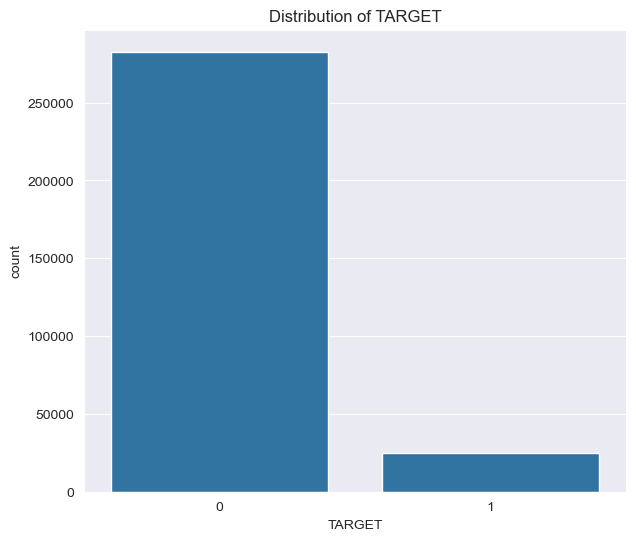

In [7]:
target_counts = df['TARGET'].value_counts(normalize=True) * 100 #Getting percentage of target
print(f'Payers (0): {target_counts[0]:.2f}%')
print(f'Non-payers (1): {target_counts[1]:.2f}%')

plt.title('Distribution of TARGET')
sns.countplot(data=df, x='TARGET');

**Note:** The dataset is highly imbalanced **(~8% defaulters)**. This will require careful attention during model validation.

## 1.5 Data Integrity Check (Sanity Check)

In this stage, we identify technical or business anomalies that will require handling during the ETL process.

In [8]:
#Statistical summary of the dataframe
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307511.000000,134133.000000,3.068510e+05,246546.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,-16036.995067,63815.045904,12.061091,2.052463,0.502130,5.143927e-01,0.510853
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,4363.988632,141275.766519,11.944812,0.509034,0.211062,1.910602e-01,0.194844
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-25229.000000,-17912.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,-19682.000000,-2760.000000,5.000000,2.000000,0.334007,3.924574e-01,0.370650
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,-15750.000000,-1213.000000,9.000000,2.000000,0.505998,5.659614e-01,0.535276
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,-12413.000000,-289.000000,15.000000,2.000000,0.675053,6.636171e-01,0.669057
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,-7489.000000,365243.000000,91.000000,3.000000,0.962693,8.549997e-01,0.896010


### 1.5.1 Anomaly Detection: DAYS_EMPLOYED

Here, we identify a potential anomaly in the `DAYS_EMPLOYED` column, as its maximum value deviates significantly from the rest of the distribution. This could be caused by a data entry error or a specific encoding for missing values.

The documentation suggests that `DAYS_EMPLOYED` should be negative (representing days elapsed relative to the application date).

In [9]:
# Counting how many lines have the anomalous value “365243”
anom = df[df['DAYS_EMPLOYED'] == 365243].shape[0]
pct_anom = (anom / df.shape[0]) * 100

print(f'Lines with 365243 days: {anom}')
print(f'Representativeness in the dataset: {pct_anom:.2f}%')

Lines with 365243 days: 55374
Representativeness in the dataset: 18.01%


**Diagnosis:** We detected that **18%** of the dataset contains the value `365243`. Dividing this by 365 results in roughly **1000 years**, which clearly indicates an error or a "magic number" representing unemployed or retired individuals.

**ETL Action:** We will replace these values with `NaN` or create a binary flag to capture this information.

### 1.5.2 Negative Age Format

The age values are recorded in negative days relative to the application date. We will analyze this feature in detail.

In [10]:
print(f"Minimum Age (days/years): {df['DAYS_BIRTH'].max()}/{df['DAYS_BIRTH'].max() / 365:.2f}")
print(f"Maximum Age (days/years): {df['DAYS_BIRTH'].min()}/{df['DAYS_BIRTH'].min() / 365:.2f}")



Minimum Age (days/years): -7489/-20.52
Maximum Age (days/years): -25229/-69.12


**Diagnosis:** No extreme outliers were detected. The data falls within a reasonable and expected range.

**ETL Action:** Convert to positive years for better interpretability.

## 1.6 Data Quality (Missing Values)

We will quantify data duplication and missing values to determine the appropriate imputation strategies.

In [11]:
# Verifying duplicates
print(f'Duplicated lines: {df.duplicated().sum()}')

Duplicated lines: 0


**Diagnosis:** No duplicate rows found. Therefore, no deduplication step is required during the ETL phase.

In [12]:
# Creating a null report dataframe
null_report = pd.DataFrame({
    'NULL (Total)': df.isnull().sum(),
    'NULL (%)': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='NULL (%)', ascending=False)

# Showing only columns that have some null values
null_report = null_report[null_report['NULL (Total)'] > 0]
null_report

,NULL (Total),NULL (%)
OWN_CAR_AGE,202929,65.990810
EXT_SOURCE_1,173378,56.381073
OCCUPATION_TYPE,96391,31.345545
EXT_SOURCE_3,60965,19.825307
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902


**Missing Values Analysis:**
* **Critical (>50%):** `OWN_CAR_AGE` and `EXT_SOURCE_1`. For car age, missing values are justified/expected as clients may not own a vehicle (`FLAG_OWN_CAR`='N'). For external scores, the absence of data may itself serve as a risk signal.
* **Significant (~15-50%):** `EXT_SOURCE_3` and `OCCUPATION_TYPE`. Occupations follow a similar logic to car age (justified by lack of active employment), though true missing data may also exist (which can be imputed as `Unknown`).
* **Low (<1%):** `AMT_GOODS_PRICE` and `AMT_ANNUITY`.

## 1.7 Correlation Analysis (Relationships)

We will examine the relationships between numerical variables. This is crucial for identifying **multicollinearity** (variables that convey the same information).

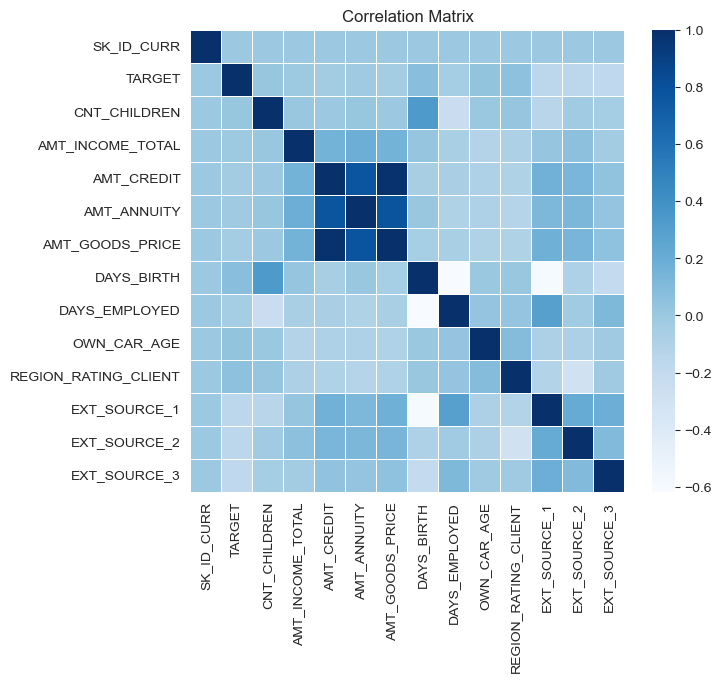

In [13]:
# Numeric columns
numeric_cols = df.dtypes[df.dtypes != 'object'].index.to_list()
correlation_matrix = df[numeric_cols].corr()

plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, cmap='Blues', linewidths=0.5);

### 1.7.1 Targeted Analysis: Credit vs. Goods Price vs. Annuity

The Heatmap reveals a strong correlation between `AMT_CREDIT`, `AMT_GOODS_PRICE`, and `AMT_ANNUITY`. We will investigate this relationship further using a scatter plot.

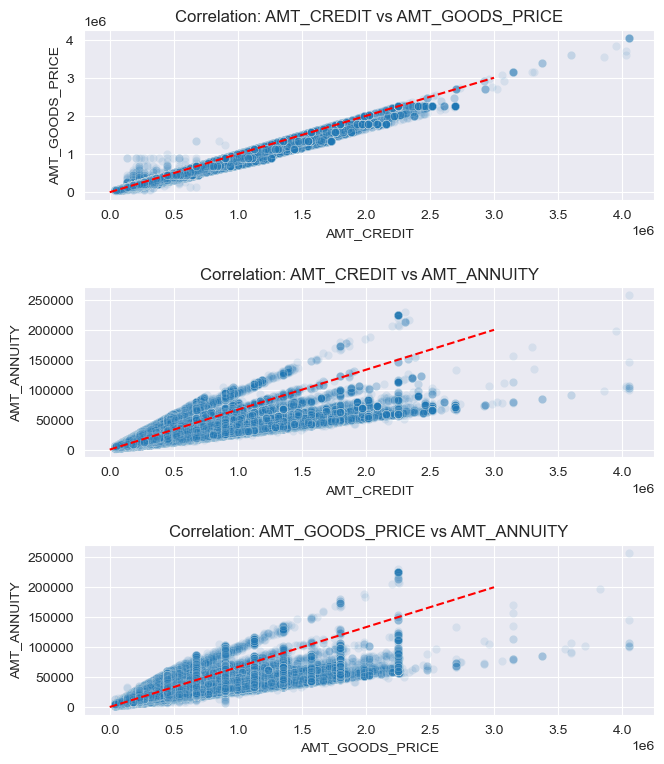

In [ ]:
from locale import normalize

scale_1 = 3000000
scale_2 = 200000

def plot_sub_scatter(x, y, s1, s2, ax):
    axes[ax].set_title(f'Correlation: {x} vs {y}')
    axes[ax].plot([0, s1], [0, s2], 'r--') # Reference Line
    sns.scatterplot(data=df, x=x, y=y, alpha=0.1, ax=axes[ax])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

# Chart 01: Credit vs Goods Price
plot_sub_scatter('AMT_CREDIT', 'AMT_GOODS_PRICE', scale_1, scale_1, 0)
# Chart 02: Credit vs Annuity
plot_sub_scatter('AMT_CREDIT', 'AMT_ANNUITY', scale_1, scale_2, 1)
# Chart 03: Goods Price vs Annuity
plot_sub_scatter('AMT_GOODS_PRICE', 'AMT_ANNUITY', scale_1, scale_2, 2)

plt.tight_layout(pad=2)


Although the plot exhibits a near-perfect correlation between `AMT_CREDIT`, `AMT_GOODS_PRICE`, and `AMT_ANNUITY`, **we will retain all three variables** at this initial stage.

**Rationale:**
1. **Latent Information:** The subtle difference between the goods price and the credit amount represents the client's **Down Payment**. Clients who provide a down payment generally pose a lower risk.
2. **Annuity Relationship:** The interaction between `AMT_CREDIT` and `AMT_ANNUITY` allows us to estimate the **Loan Term**, which is not explicitly available in the dataset.

**ETL Decision:**
We will retain all three columns (`CREDIT`, `GOODS_PRICE`, `ANNUITY`). In the subsequent notebook (Feature Engineering), we will engineer derived features (ratios and differences) to capture these specific business behaviors.

## 1.8 Conclusions & ETL Action Plan

We conclude the Data Understanding phase with the following key diagnoses:

1. **Distribution:** Significant class imbalance detected in the `TARGET` variable.
2. **Data Integrity:** Identified a critical anomaly in `DAYS_EMPLOYED` (value `365243`), affecting 18% of the dataset.
3. **Format:** Date-related columns (`DAYS_...`) are negative and require conversion to absolute years.
4. **Data Quality:** `EXT_SOURCE_1` & `3`, `OCCUPATION_TYPE`, and `OWN_CAR_AGE` necessitate careful imputation strategies. `AMT_GOODS_PRICE`, `AMT_CREDIT`, and `AMT_ANNUITY` exhibit strong logical correlations.

### 1.8.1 Next Step: Data Preparation (Notebook 02)

Based on this diagnosis, the roadmap for the next notebook is defined as follows:

* **Anomaly Handling:** Replace `365243` with `NaN` in `DAYS_EMPLOYED` and convert both `DAYS_EMPLOYED` and `DAYS_BIRTH` to positive values.
* **Feature Removal:** Evaluate the necessity of dropping `OWN_CAR_AGE` due to the high percentage of missing values.
* **Imputation Strategy:**
    * Impute `AMT_ANNUITY` using the **Median** (robust to outliers and low missing count).
    * Impute `AMT_GOODS_PRICE` using `AMT_CREDIT` values.
    * Retain `NaN` in `EXT_SOURCE` features (suitable for tree-based models) or experiment with an Iterative Imputer.
    * Impute `OCCUPATION_TYPE` (use 'Unknown' or 'N/A' for pensioners/unemployed).
* **Feature Engineering:**
    * Create `AGE` column (Age in Years).
    * Create `DEBT_TO_INCOME_RATIO` (`AMT_ANNUITY` / `AMT_INCOME_TOTAL`) to measure income commitment.
    * Create `PAYMENT_RATE` (`AMT_ANNUITY` / `AMT_CREDIT`) to assess the annual loan burden relative to total debt.
    * Create `DOWN_PAYMENT` (`AMT_GOODS_PRICE` - `AMT_CREDIT`).